<center><h1 style="color:white;"><b>Computer Assignment 1</b></h1>
<h3 style="color:white;">Narges Mohammadi Elyasi 810100258</h3></center>

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Knapsack Problem Description</title>
</head>
<body>

<h2>Problem Description:</h2>

<p>Given a knapsack with a maximum weight capacity <em>W</em>, a set of <em>n</em> snacks, each with a weight <em>w<sub>i</sub></em> and a value <em>v<sub>i</sub></em>, where <em>1 &le; i &le; n</em>. Additionally, there are constraints:</p>

<ul>
  <li>The total weight of selected snacks cannot exceed <em>W</em>.</li>
  <li>The total value of selected snacks must be at least <em>V<sub>min</sub></em>.</li>
  <li>The number of distinct types of snacks selected must fall within the range [<em>K<sub>min</sub></em>, <em>K<sub>max</sub></em>].</li>
  <li>The weight selected from each snack cannot exceed its available weight <em>w<sub>max</sub></em>.</li>
</ul>

<h2>Goal:</h2>

<p>Maximize the total value of selected snacks while adhering to the specified constraints.</p>

</body>
</html>


Let's start by importing the libraries we need:

In [623]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import time
from copy import deepcopy
import matplotlib.pyplot as plt


First, we load the data and check some of its' features

In [624]:
data =  pd.read_csv("snacks.csv")

In [625]:
data.head(10)

,Snack,Available Weight,Value
0,MazMaz,10,10
1,Doogh-e-Abali,15,10
2,Nani,5,5
3,Jooj,7,15
4,Hot-Dog,20,15
5,Chips,8,6
6,Nooshaba,12,8
7,Shokolat,6,7
8,Chocoroll,9,12
9,Cookies,11,11


In [626]:
data.describe()

,Available Weight,Value
count,19.000000,19.000000
mean,9.684211,9.473684
std,4.497563,3.168744
min,3.000000,4.000000
25%,6.500000,7.000000
50%,9.000000,10.000000
75%,12.500000,11.500000
max,20.000000,15.000000


<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Constants</title>
<style>
  body {
    font-size: 20px;
  }
  li {
    font-size: 15px;
  }
</style>
</head>
<body>

<h2>Defining Constants:</h2>

<ul>
  <li><strong>weight_limit:</strong> The maximum weight capacity of the knapsack.</li>
  <li><strong>count_upper_bound:</strong> The maximum number of distinct types of snacks allowed to be selected.</li>
  <li><strong>count_lower_bound:</strong> The minimum number of distinct types of snacks required to be selected.</li>
  <li><strong>population_length:</strong> The size of the population (number of chromosomes) in the genetic algorithm.</li>
  <li><strong>p_crossover:</strong> The probability of crossover occurring between two parent chromosomes during reproduction.</li>
  <li><strong>p_mutation:</strong> The probability of mutation occurring in a chromosome during reproduction.</li>
</ul>

</body>
</html>




In [627]:
COUNT_OF_SNACKS = len(data)

@dataclass
class Constants:
    limit_generation : int
    population_length: int
    p_crossover: float
    p_mutation: float
    

In [628]:
#CONSTRAINTS
WEIGHT_LIMIT= 10 
COUNT_LOWER_BOUND= 2
COUNT_UPPER_BOUND= 4
MIN_VALUE = 12
    

# Generate chromosme

Each gene represents a number between 0 and 1, so the chromosome is representing a string of these numbers of size len of csv file.

We make a random chromosome by creating a list and giving each item of the list a random value. Now it is time to normalize the chromosome to scale the data to a common range.

In [629]:
def normalize_chromosome(chromosome):
    threshold = chromosome.sum() / (COUNT_OF_SNACKS * 10) 
    chromosome[chromosome < threshold] = 0

    weight = (data['Available Weight'].to_numpy() * chromosome).sum()
    return chromosome * (10 / (weight + 1e-9))

def generate_random_chroms():
    return normalize_chromosome(np.random.rand(1, COUNT_OF_SNACKS))
    


# Initial population
This function generates an initial population for the genetic algorithm. It first creates an empty 2D NumPy array with dimensions size of population and lenght of items. Then, for each chromosome in the population, it generates a random number between 0 and 1 for each gene, corresponding to a specific item in the item_list. 

In [630]:
def init_population(population_length):
    population = np.empty(shape=(population_length, COUNT_OF_SNACKS))
    for i in range(population_length):
        population[i][:] = generate_random_chroms()
    return population



In [631]:
# Example: Print the first few chromosomes
for i, chromosome in enumerate(init_population(5)):
    print(f"Chromosome {i+1}: Selected snacks weights {chromosome}")

Chromosome 1: Selected snacks weights [0.07985196 0.01002519 0.03436175 0.03126959 0.02660464 0.05248619
 0.07403221 0.0786603  0.06397633 0.07750839 0.04434046 0.07791471
 0.06931842 0.04184795 0.07483175 0.08069421 0.04773349 0.
 0.07161289]
Chromosome 2: Selected snacks weights [0.05639107 0.04459455 0.02147362 0.0559149  0.08131225 0.09637333
 0.09769599 0.02563984 0.03747532 0.03770615 0.06119114 0.02640618
 0.05103569 0.         0.08942874 0.0534994  0.09112258 0.00601693
 0.03908566]
Chromosome 3: Selected snacks weights [0.07026618 0.07297381 0.02593144 0.04194529 0.0092933  0.08904517
 0.08415764 0.07778709 0.02747701 0.01346682 0.06725737 0.07992043
 0.06194311 0.04148663 0.06533648 0.01937151 0.07170404 0.07955579
 0.04135148]
Chromosome 4: Selected snacks weights [0.03739833 0.03588147 0.07617723 0.         0.12539021 0.112157
 0.13337228 0.08538543 0.06144591 0.01188556 0.02194722 0.
 0.         0.03609306 0.08362489 0.02640252 0.04593729 0.08541716
 0.01928223]
Chromosome

After making the whole population, we have to define a fitness function in order to identify the best solutions.
According to the knapsack, the fitness function should be in a way that chooses the solutions that maximize the total value of the backpack, and also doesn't exceed the weight limit.

$$  value(chromosome) = \sum_{i=1}^{N} v_i \cdot x_i \geq V  $$

$$  weight(chromosome) = \sum_{i=1}^{N} w_i \cdot x_i \leq W $$

$$ 2 \leq count Of Snacks \leq 4 $$

$$ weight Punishment(chromosome) = (weight > 10)(weight - 10) * c1 $$

$$ num Punishment(chromosome) =(num > 4) * (num - 4)
                                (num < 2) * (2 - num) $$

In [632]:
def punishment(chromosome):
    C1, C2 ,C3= 1, 1,1
    weight = (data['Available Weight'].to_numpy() * chromosome).sum()
    weight_punishment = ((weight > WEIGHT_LIMIT) * (weight - WEIGHT_LIMIT)) * C1
    num = np.count_nonzero(chromosome)
    num_punishment = ((num > COUNT_UPPER_BOUND) * (num - COUNT_UPPER_BOUND) +
                       (num < COUNT_LOWER_BOUND) * (COUNT_LOWER_BOUND - num)) * C2
    total_value = (chromosome * data["Value"].to_numpy()).sum()
    value_punishment = (total_value - MIN_VALUE ) * C3  
    total_punishment = weight_punishment + num_punishment 

    return total_punishment
    

def calc_fitness(chromosome):    
    total_value = (chromosome * data["Value"].to_numpy()).sum()
    fitness = total_value - punishment(chromosome)
    return fitness

In [633]:
calc_fitness(generate_random_chroms())

-4.059291117324303

# Crossover Function:
When we execute this function, we're essentially performing a one-point crossover operation in genetic algorithms. If the randomly generated value is greater than the specified crossover probability, we keep the original parents. However, if it's less than or equal to the crossover probability, we randomly select a crossover point. Then, we swap genetic material between the parents at that point to create two children. Finally, we return these children as the result.

In [634]:
def crossover_one_point(parents: tuple , p_crossover = 0) -> tuple :
    if np.random.random(1) > p_crossover:
        return parents
    par_a, par_b = parents
    crossover_point = np.random.randint(COUNT_OF_SNACKS)
    child_a = np.concatenate((par_a[crossover_point:], par_b[:crossover_point]))
    child_b = np.concatenate((par_b[crossover_point:], par_a[:crossover_point]))
    return (normalize_chromosome(child_a), normalize_chromosome(child_b))        

# Mutation Function:
when we execute this function, we're essentially performing a mutation operation in genetic algorithms. If the randomly generated value is greater than the specified mutation rate, we simply return the original chromosome. However, if it's less than or equal to the mutation rate, we proceed to randomly select an index within the chromosome. Then, we replace the value at that index with a new randomly generated value.  

In [635]:
def mutate(chromosome, p_mutation):
    if np.random.random() > p_mutation:
        return chromosome
    index = np.random.randint(COUNT_OF_SNACKS)
    chromosome[index] = np.random.random()

    return normalize_chromosome(chromosome)


## Testing the result 

in this function, we begin by setting up an intial population, then iteratively refines it over a fixed number of generations. In each generation, we normalizes the chromosome. perform crossover and mutation to create the new population accordingly. The best fitness value of each generation is tracked and plotted. If a valid solution satisfying constraints is found, the algorithm terminates early. Finally, it returns the best solution found along with its total value and weight.

In [636]:
def chromsagh(constants):
    
    population = init_population(constants.population_length)
    n_generation = 0
    best_fitnesses = []
    while n_generation < constants.limit_generation:
        fitnesses = np.apply_along_axis(calc_fitness, axis = 1, arr = population)
        print(f"max fitness for {n_generation+1}th generation:",fitnesses.max())
        best_fitnesses.append(fitnesses.max())
        sorted_indices = np.argsort(fitnesses)
        population = population[sorted_indices]
        indicies = np.arange(0, constants.population_length, 1)
        prob = indicies / indicies.sum()
        
        children = np.empty(shape=(constants.population_length, COUNT_OF_SNACKS))
        for i in range(constants.population_length // 2):
            parents = np.random.choice(
                indicies,
                2,
                p = prob
            )
            shooshoo = population[parents[0]]
            wifey = population[parents[1]]
            childs = crossover_one_point((shooshoo, wifey), constants.p_crossover)
            first_child = mutate(childs[0], constants.p_mutation)
            second_child = mutate(childs[1], constants.p_mutation)

            children[i] = first_child
            children[constants.population_length // 2 + i] = second_child
        population = deepcopy(children)
        n_generation += 1
    np.savetxt('genetic_algorithm_results.csv', population, delimiter=',')
    # Plotting
    best_fitnesses.sort()
    plt.plot(best_fitnesses)
    plt.title('Best Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.show()
    
    return population
    
 


max fitness for 1th generation: -1.2007944302081661
max fitness for 2th generation: 0.9216856502658857
max fitness for 3th generation: 0.7332524850876485
max fitness for 4th generation: 2.790817498299683
max fitness for 5th generation: 2.3481743540660105
max fitness for 6th generation: 2.040197532973849
max fitness for 7th generation: 4.858319356126275
max fitness for 8th generation: 4.858319355840294
max fitness for 9th generation: 4.858319355840294
max fitness for 10th generation: 7.790321306162001
max fitness for 11th generation: 7.794521166469702
max fitness for 12th generation: 8.196793857309673
max fitness for 13th generation: 9.260567960740111
max fitness for 14th generation: 8.769603538373893
max fitness for 15th generation: 10.013182643479796
max fitness for 16th generation: 12.87691753606326
max fitness for 17th generation: 13.589167891389192
max fitness for 18th generation: 11.710275172015185
max fitness for 19th generation: 12.948518318424897
max fitness for 20th generation

max fitness for 48th generation: 22.333333326333335
max fitness for 49th generation: 22.333333326333335
max fitness for 50th generation: 20.428571402612345
max fitness for 51th generation: 22.333333331
max fitness for 52th generation: 22.333333314515492
max fitness for 53th generation: 22.333333323468008
max fitness for 54th generation: 21.723107453300397
max fitness for 55th generation: 22.333333326333335
max fitness for 56th generation: 22.333333331000002
max fitness for 57th generation: 22.61160895416792
max fitness for 58th generation: 20.71659608114862
max fitness for 59th generation: 22.33333332788889
max fitness for 60th generation: 22.333333327888887
max fitness for 61th generation: 22.421183382237093
max fitness for 62th generation: 22.41891992643687
max fitness for 63th generation: 22.41891992643687
max fitness for 64th generation: 22.333333324795877
max fitness for 65th generation: 22.333333331
max fitness for 66th generation: 22.64787877031662
max fitness for 67th generatio

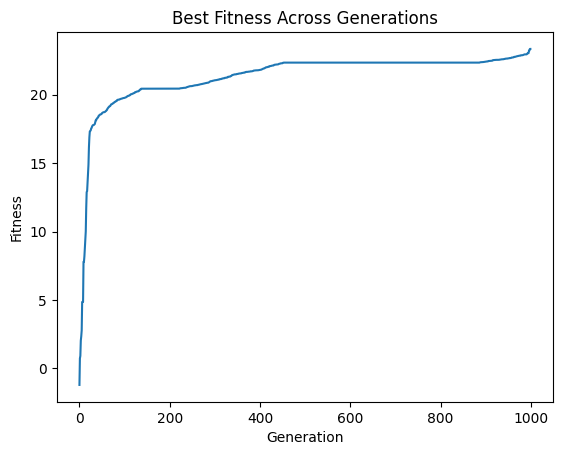

In [637]:
constants = Constants(1000,200,0.9,0.1)
genZ = chromsagh(constants)

The plot displays the trend of the best fitness value across generations during the execution of the genetic algorithm. Each point on the plot represents the best fitness value achieved in each generation. As the algorithm progresses through generations, the plot illustrates how the fitness of the best solution found so far evolves over time. This visualization helps in understanding the convergence behavior of the algorithm and whether it is making progress towards finding an optimal solution. If the plot shows an increasing trend or stabilizes at a high fitness value, it indicates that the algorithm is successfully improving solutions. On the other hand, if the plot remains flat or fluctuates without improvement, it suggests that the algorithm may be struggling to find better solutions or may have converged prematurely.

In [638]:
value = (genZ * data['Value'].to_numpy()).sum(axis=1).max()
weight = (genZ * data['Available Weight'].to_numpy()).sum(axis=1).max()
print("Total value of selected items:",value)
print("Total weight of selected items:",weight)

Total value of selected items: 23.33333331765609
Total weight of selected items: 9.999999999800002


<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title style="color: blue;">Genetic Algorithm Questions</title>
  <style>
    body {
      font-family: Arial;
      line-height: 1.6;
    }
    p {
      margin-bottom: 20px;
    }
  </style>
</head>
<body>
  <h2>Genetic Algorithm Questions</h2>
  <ol>
    <li>
      <strong>What happens if our population is too big or small?</strong>
      <p>If there are lots of individuals in the population, we might find the best solution faster because there's more variety to choose from. But it also means the computer needs more time and memory. If there are only a few individuals, there's less variety, so it's harder to find the best solution. We might not even find it at all.</p>
    </li>
    <li>
      <strong>What happens if the population increases after each generation?</strong>
      <p>If we make the population bigger with each generation, it means there are more and more individuals to choose from. This can be helpful because it increases the diversity of possible solutions. However, it also means the computer needs more time and memory to handle all those individuals. Usually, we keep the population the same size throughout to help the chromosomes converge to the best solution. If we make the population bigger, it might actually make it harder for the chromosomes to converge to that best solution.</p>
    </li>
    <li>
      <strong>What are the effects of crossover and mutation and what happens if we use only one of them?</strong>
      <p>Crossover and mutation are both important operations in genetic algorithms. Crossover combines good chromosomes to create better ones, while mutation directly changes the genes of a chromosome, helping to explore new possibilities and escape local optima. If we use only one of them, we may encounter limitations. For instance, relying solely on crossover may not lead to an optimal solution, as mutation introduces necessary randomness to explore new areas of the solution space. Conversely, only using mutation might not result in convergence to the best solution because it lacks the effectiveness of crossover in combining beneficial traits. However, in certain scenarios with specific parameters, solely relying on mutation may lead to the answer.</p>
    </li>
    <li>
      <strong>What are some ways to find the answer faster?</strong>
      <p>Experimenting with algorithm parameters can help find optimal settings for faster convergence. Additionally, adjusting crossover and mutation rates, population size, and termination conditions can enhance performance.</p>
    </li>
    <li>
      <strong>How can we solve the problem of chromosomes getting stuck after some generations?</strong>
      <p>Using mutation can help prevent chromosomes from getting stuck in local optima. Alternatively, employing multi-start strategies by running the algorithm with different initial populations can increase exploration and potentially find better solutions.</p>
    </li>
    <li>
      <strong>What can we do to stop the algorithm if the problem doesn't have any solutions?</strong>
      <p>Setting a maximum generation limit can prevent the algorithm from running indefinitely. If no solutions are found within the limit, the algorithm can return the chromosome with the best fitness in the final population.</p>
    </li>
  </ol>
</body>
</html>
